In [5]:
import numpy as np
from scipy import special
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14

# Calculation of vertical displacement due to loading

## Step1: Comparision with Argus et al. (2017)

$$ d = Gm $$

- d: data (displacement; $n_d\times1$)
- m: model (mass; $n_m\times1$)

In [6]:
def calc_deformation_disk(M, lamda, mu, alpha, r):
    ''' 
    Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mu.
    M: mass of the disk, kg
    lamda: Lame parameter of substrate
    mu: shear modulus of substrate
    alpha: disk radius, in metres
    r: array of distances from centre of disk at which to calculate solution. In metres. eg r = np.linspace(0,50*10**3,num=1000) to go to 50km distance.
    
    '''
    sigma=lamda+2*mu
    nabla=lamda + mu
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M * g* (sigma/(np.pi**2 * mu * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )  
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm

In [7]:
# These are the displacements which I picked by hand from Argus 2017
argus_traced_14_disp = -1*np.array([2.6, 2.3, 1.4, 0.7, 0.3, 0.15]) 
# And these are the corresponding distances in kilometres
argus_traced_14_distance = [0,9,16,20,36,50]

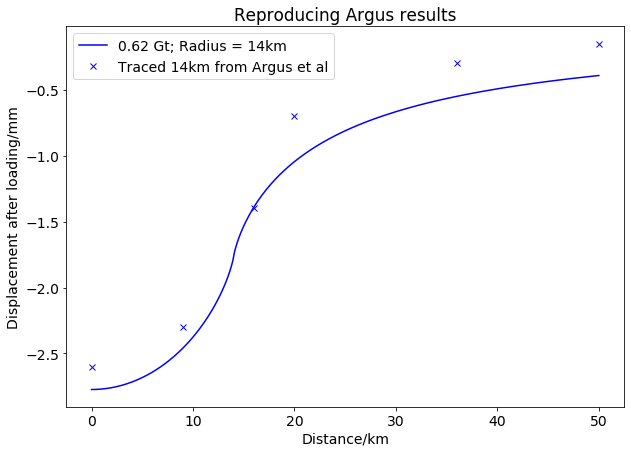

In [8]:
g = 9.81 # Seogi: gravity acceleration?
lamda = 25*10**9 # Lame parameter of granite
mu = 40*10**9 # Shear modulus of granite
M = np.pi * (14*10**3)**2 * 1 * 1000
alpha = 14*10**3
r_argus = np.linspace(0,50*10**3,num=1000)

delta_d = calc_deformation_disk(M,lamda,mu,alpha,r_argus)
#delta_d_2d = calc_deformation_2Ddisk(M,lamda,mu,alpha,r_argus)

fig,ax = plt.subplots(1,1,figsize=(10,7))
plt.plot(
    r_argus/1000,delta_d*1000,color='blue',
    label="0.62 Gt; Radius = 14km"
) 
plt.plot(
    argus_traced_14_distance,argus_traced_14_disp,'x',
    color='blue',
    label="Traced 14km from Argus et al"
)

plt.xlabel('Distance/km')
plt.ylabel('Displacement after loading/mm')

plt.title("Reproducing Argus results")


plt.legend()
plt.show()

## Step2: Create SimPEG `Problem` class

In [43]:
from SimPEG.Problem import BaseProblem
from SimPEG.Survey import BaseSurvey
from SimPEG import Props, Maps

class SWEProblem(BaseProblem):
    
    mass, massMap, massDeriv = Props.Invertible(
        "Mass (kg)"
    )

    mu = Props.PhysicalProperty(
        "Shear modulus (??)",
        default=40.*10**9
    )
    
    alpha = Props.PhysicalProperty(
        "Disk radius (m)",
        default=14.*10**3
    )
    
    lamda = Props.PhysicalProperty(
        "Lame parameter (??)",
        default=25.*10**9
    )    
    
    _G = None
    cylinder_locations = None
    
    def __init__(self, mesh, **kwargs):
        BaseProblem.__init__(self, mesh, **kwargs)
        mapPair = Maps.IdentityMap  #: Type of mapping to pair with

    def fields(self, m):
        self.model = m
        return self.G.dot(self.massMap * m)

    def getJ(self, m, f=None):
        """
            Sensitivity matrix
        """

        if self.massMap is not None:
            dmudm = self.massMap.deriv(m)
            return self.G*dmudm
        else:
            return self.G

    @property
    def G(self):
        """
        Calculate G matrix to have a linear equation
        
        d = Gm
        
        """
        if getattr(self, '_G', None) is None:
            # assume a single disk at the moment
            # Todo: extend this for multiple cylinders?
            nM = self.mesh.nC
            self._G = np.zeros((self.survey.nD, nM))
            
            for ii in range(nM):
                sigma=self.lamda+2*mu
                nabla=self.lamda+mu
                r = np.sqrt(((self.survey.rx_locations-self.cylinder_locations[ii,:])**2).sum(axis=1))
                r_disk = r[r<=alpha]
                r_postdisk = r[r>=alpha]
                self._G[r<=alpha,ii] =-g* (
                    sigma/(np.pi**2 * mu * nabla * alpha) * 
                    special.ellipe((r_disk/alpha)**2) 
                )  # set the rows of G for receivers within the cylinder.
                self._G[r>=alpha,ii] = -g * (
                    (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * 
                    (
                        special.ellipe((alpha/r_postdisk)**2) - 
                        (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)
                    ) # set the rows of G for recievers outside the cylinder.
                )
        return self._G
    
    def Jvec(self, m, v, f=None):
        return self.G.dot(self.massMap.deriv(m) * v)

    def Jtvec(self, m, v, f=None):
        return self.massMap.deriv(m).T*self.G.T.dot(v)
    
class SWESurvey(BaseSurvey):
    
    rx_locations = None

    def __init__(self, **kwargs):
        BaseSurvey.__init__(self, **kwargs)
    
    def eval(self, f):
        return f

    @property
    def nD(self):
        return self.rx_locations.shape[0]

In [44]:
from SimPEG import Mesh

In [75]:
mesh = Mesh.TensorMesh([2,1,1])
cylinder_locations = np.array([[0, 0, 0],[10*10**3,0,0]])
x = np.linspace(0,50*10**3,num=1000)
y = np.zeros_like(x)
z = np.zeros_like(x)

rx_locations = np.c_[x, y, z]
prob = SWEProblem(
    mesh, 
    massMap = Maps.IdentityMap(mesh),
    cylinder_locations=cylinder_locations,
    mu=np.array([mu, mu]),
    alpha=np.array([alpha, alpha]),    
)
survey = SWESurvey(rx_locations=rx_locations)
prob.pair(survey)
model = np.array([M,M])
data = survey.dpred(model)

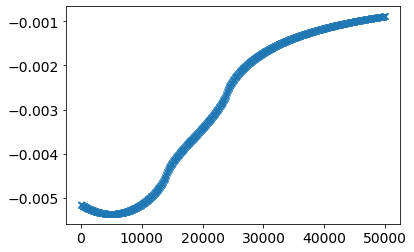

In [77]:
plt.plot(survey.rx_locations[:,0],data,'x')
#plt.plot(delta_d, '.')

AttributeError: 'SWESurvey' object has no attribute '_G'

In [62]:
prob._G


array([[-4.50377882e-15, -3.16042651e-16],
       [-4.50376443e-15, -3.16201696e-16],
       [-4.50372126e-15, -3.16360901e-16],
       ...,
       [-6.38201737e-16, -6.35599002e-16],
       [-6.37549036e-16, -6.36247672e-16],
       [-6.36897682e-16, -6.36897682e-16]])

In [63]:
model

array([6.1575216e+11, 6.1575216e+11])

In [64]:
prob.cylinder_locations


array([[     0,      0,      0],
       [100000,      0,      0]])

In [65]:
survey.rx_locations


array([[    0.        ,     0.        ,     0.        ],
       [   50.05005005,     0.        ,     0.        ],
       [  100.1001001 ,     0.        ,     0.        ],
       ...,
       [49899.8998999 ,     0.        ,     0.        ],
       [49949.94994995,     0.        ,     0.        ],
       [50000.        ,     0.        ,     0.        ]])

In [66]:
data

array([-0.00296782, -0.0029679 , -0.00296798, -0.00296803, -0.00296807,
       -0.00296808, -0.00296809, -0.00296807, -0.00296803, -0.00296798,
       -0.00296791, -0.00296783, -0.00296772, -0.0029676 , -0.00296746,
       -0.0029673 , -0.00296712, -0.00296693, -0.00296672, -0.00296649,
       -0.00296625, -0.00296598, -0.0029657 , -0.0029654 , -0.00296508,
       -0.00296475, -0.00296439, -0.00296402, -0.00296364, -0.00296323,
       -0.00296281, -0.00296236, -0.0029619 , -0.00296143, -0.00296093,
       -0.00296042, -0.00295988, -0.00295934, -0.00295877, -0.00295818,
       -0.00295758, -0.00295696, -0.00295632, -0.00295566, -0.00295498,
       -0.00295429, -0.00295358, -0.00295285, -0.0029521 , -0.00295133,
       -0.00295055, -0.00294975, -0.00294893, -0.00294809, -0.00294723,
       -0.00294635, -0.00294546, -0.00294454, -0.00294361, -0.00294266,
       -0.00294169, -0.0029407 , -0.0029397 , -0.00293867, -0.00293763,
       -0.00293657, -0.00293549, -0.00293439, -0.00293327, -0.00

In [72]:
survey.rx_locations[:,0]


array([    0.        ,    50.05005005,   100.1001001 ,   150.15015015,
         200.2002002 ,   250.25025025,   300.3003003 ,   350.35035035,
         400.4004004 ,   450.45045045,   500.5005005 ,   550.55055055,
         600.6006006 ,   650.65065065,   700.7007007 ,   750.75075075,
         800.8008008 ,   850.85085085,   900.9009009 ,   950.95095095,
        1001.001001  ,  1051.05105105,  1101.1011011 ,  1151.15115115,
        1201.2012012 ,  1251.25125125,  1301.3013013 ,  1351.35135135,
        1401.4014014 ,  1451.45145145,  1501.5015015 ,  1551.55155155,
        1601.6016016 ,  1651.65165165,  1701.7017017 ,  1751.75175175,
        1801.8018018 ,  1851.85185185,  1901.9019019 ,  1951.95195195,
        2002.002002  ,  2052.05205205,  2102.1021021 ,  2152.15215215,
        2202.2022022 ,  2252.25225225,  2302.3023023 ,  2352.35235235,
        2402.4024024 ,  2452.45245245,  2502.5025025 ,  2552.55255255,
        2602.6026026 ,  2652.65265265,  2702.7027027 ,  2752.75275275,
      